# How to work with Climate Adaptation Digital Twin data on Earth Data Hub: fields on a single level or surface, standard resolution

***
This document will provide you guidance on how to create your own user story on Climate Adaptation DT data hosted on the DESP Core Service Platform.
The first goal is to plot the mean 2 metre temperature in January 2029 over Central Europe.
The second goal is to compute the 2 metre temperature climatology (monthly means and standard deviations) in Berlin for the 2020-2028 reference period.

***

## What you will learn

* How to access and preview the dataset
* How to select and reduce the data
* How to plot the results

***
## Prerequisites

1. Create a Python environment (as explained [here](https://support.com)) and run the following commands:
```
pip install xarray[complete]
pip install requests
pip install aiohttp
pip install display
pip install ipykernel
pip install cartopy
```
3. Install kernel `climate-dt`. Run the command:
```
ipython kernel install --user --name=climate-dt
```
4. Select the kernel `climate-dt` from the top-right menu of this notebook
5. Generate a file named `~/.netrc`. Open a Terminal and type:
```
cat << EOF > ~/.netrc
machine data.earthdatahub.com
   login username
   password password
EOF
```
> Replace username and password with your own credentials.
***

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. It is a smart approach reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [1]:
import xarray as xr

ds = xr.open_dataset(
    "https://data.earthdatahub.com/destine-climate-dt/SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    engine="zarr",
    chunks={},
    storage_options={"client_kwargs": {"trust_env": "true"}},
)
ds

<xarray.Dataset> Size: 82TB
Dimensions:            (time: 87672, latitude: 4096, longitude: 8193)
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 33kB -90.0 -89.96 ... 89.96 90.0
  * longitude          (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 701kB 2020-01-01 ... 2029-12-31T...
Data variables:
    d2m                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ssr                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    str                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    t2m                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate             (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10                (time, latitude, longitude) float32 12TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-04-03T18:54 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## 2 metre temperature: average January 2029 in Germany

### 1. Data selection

First, we perform a geographical selection corresponding to the Germany area. This greatly reduces the amount of data that will be downloaded from EDH. Also, we convert the temperature to `°C`.

In [2]:
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m_germany_area = t2m.sel(**{"latitude": slice(47, 55), "longitude": slice(5, 16)})
t2m_germany_area

<xarray.DataArray 't2m' (time: 87672, latitude: 182, longitude: 251)> Size: 16GB
dask.array<getitem, shape=(87672, 182, 251), dtype=float32, chunksize=(48, 182, 251), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 1kB 47.01 47.05 47.1 ... 54.92 54.97
  * longitude          (longitude) float64 2kB 5.01 5.054 5.098 ... 15.95 16.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 701kB 2020-01-01 ... 2029-12-31T...
Attributes:
    units:    C

!NB: At this point, no data has been downloaded yet, nor loaded in memory.

Second, we further select January 2029. This is again a lazy operation:

In [3]:
t2m_germany_area_january_2029 = t2m_germany_area.sel(time="2029-01")
t2m_germany_area_january_2029

<xarray.DataArray 't2m' (time: 744, latitude: 182, longitude: 251)> Size: 136MB
dask.array<getitem, shape=(744, 182, 251), dtype=float32, chunksize=(48, 182, 251), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
  * latitude           (latitude) float64 1kB 47.01 47.05 47.1 ... 54.92 54.97
  * longitude          (longitude) float64 2kB 5.01 5.054 5.098 ... 15.95 16.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 6kB 2029-01-01 ... 2029-01-31T23...
Attributes:
    units:    C

At this point the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [4]:
%%time

t2m_germany_area_january_2029 = t2m_germany_area_january_2029.compute()

CPU times: user 2.79 s, sys: 1.66 s, total: 4.45 s
Wall time: 9.42 s


The data was very small, this didn't take long.

### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the october 2023 monthly mean:

In [5]:
t2m_germany_area_january_2029_monthly_mean = t2m_germany_area_january_2029.mean(dim="time")
t2m_germany_area_january_2029_monthly_mean

<xarray.DataArray 't2m' (latitude: 182, longitude: 251)> Size: 183kB
array([[ 0.68535554,  0.68535554,  0.7965779 , ..., -5.1183825 ,
        -5.1183825 , -5.0227857 ],
       [ 0.68535554,  0.5748045 ,  0.712909  , ..., -5.137872  ,
        -5.137872  , -5.065124  ],
       [ 0.5748045 ,  0.5418744 ,  0.5418744 , ..., -5.137872  ,
        -5.182563  , -5.065124  ],
       ...,
       [ 1.0253823 ,  1.0253823 ,  1.0317667 , ..., -2.6698341 ,
        -2.8227232 , -2.8227232 ],
       [ 1.0317667 ,  1.0317667 ,  1.0317667 , ..., -2.5397935 ,
        -2.4208417 , -2.684619  ],
       [ 1.020006  ,  1.020006  ,  1.020006  , ..., -2.4208417 ,
        -2.4208417 , -2.5381134 ]], dtype=float32)
Coordinates:
    heightAboveGround  float64 8B 2.0
  * latitude           (latitude) float64 1kB 47.01 47.05 47.1 ... 54.92 54.97
  * longitude          (longitude) float64 2kB 5.01 5.054 5.098 ... 15.95 16.0
    step               timedelta64[ns] 8B 00:00:00
    surface            float64 8B 0.0

## 3. Visualization
Finally, we can plot the january 2029 monthly mean on a map:

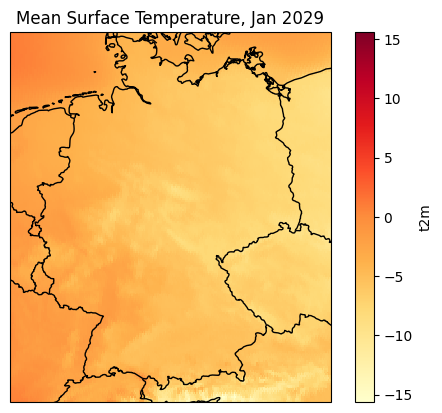

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

ax = plt.axes(projection=ccrs.Mercator())
t2m_germany_area_january_2029_monthly_mean.plot(ax=ax,transform=ccrs.PlateCarree(),cmap="YlOrRd",vmax=None)  
plt.title("Mean Surface Temperature, Jan 2029")
ax.coastlines()
ax.add_feature(cf.BORDERS)
plt.show()

## 2020-2028 climatology

We will now compute the 2 metre temperature climatology (montly mean and standard deviation) in Berlin for the reference period 2020-2028.

We first select the closet data to Berlin:

In [7]:
%%time

t2m_Berlin_2020_2028 = t2m.sel(**{"latitude": 52.5, "longitude": 13.4}, method="nearest").sel(time=slice("2020", "2028"))
t2m_Berlin_2020_2028

CPU times: user 23.4 ms, sys: 0 ns, total: 23.4 ms
Wall time: 20.4 ms


<xarray.DataArray 't2m' (time: 78912)> Size: 316kB
dask.array<getitem, shape=(78912,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 8B ...
    latitude           float64 8B 52.51
    longitude          float64 8B 13.4
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 631kB 2020-01-01 ... 2028-12-31T...
Attributes:
    units:    C

This is already small enought to be computed:

In [8]:
%%time

t2m_Berlin_2020_2028 = t2m_Berlin_2020_2028.compute()

CPU times: user 3min 16s, sys: 2min 21s, total: 5min 37s
Wall time: 6min 57s


Now that the data is loaded in memory we can easily compute the climatology:

In [9]:
t2m_Berlin_climatology_mean = t2m_Berlin_2020_2028.groupby("time.month").mean(dim="time")
t2m_Berlin_climatology_std = t2m_Berlin_2020_2028.groupby("time.month").std(dim="time")

We can finally plot the climatology in Berlin for the 2020-2028 refrence period

In [10]:
import matplotlib.pyplot as plt

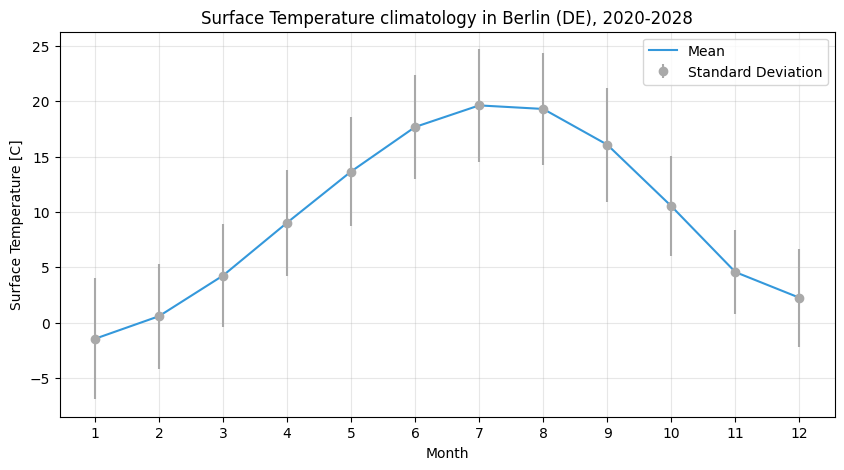

In [11]:
plt.figure(figsize=(10, 5))
t2m_Berlin_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_Berlin_climatology_mean.month, 
    t2m_Berlin_climatology_mean, 
    yerr=t2m_Berlin_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)

plt.title("Surface Temperature climatology in Berlin (DE), 2020-2028")
plt.xticks(t2m_Berlin_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()